In [201]:
import glob
import multiprocessing
import random
import time
import enum

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchio as tio
import torchvision
from tqdm import tqdm

from unet import UNet

from scripts.utils.memory import get_total_memory
from scripts.utils.visualization import visualize_subject, visualize_slice
from scripts.utils.loading import get_subjects_names
from scripts.load_data import load_2D, load_3D
seed = 42
random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)
print('Device:', device)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last run on Thu Jul  6 17:47:17 2023
TorchIO version: 0.18.92
Device: cuda


# Data Loading and Visualization

In [3]:
metadata_path = "Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
metadata = pd.read_csv(metadata_path, index_col=1).drop(columns="Unnamed: 0")
metadata.head(5)

,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight
External code,,,,,,,,,,
A0S9V9,Siemens,A,1,0,9,67,DCM,M,180.0,88.0
A1D0Q7,Philips,B,2,0,9,79,HCM,F,NaN,88.0
A1D9Z7,Siemens,A,1,22,11,53,HCM,M,175.0,75.0
A1E9Q1,Siemens,A,1,0,9,16,DCM,M,175.0,75.0
A1K2P5,Canon,D,5,33,11,35,DCM,F,170.0,NaN


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:16<00:00,  9.12it/s]


Training/Labeled/ Dataset size: 150 subjects
Memory function not implemented for 2D
Total memory for train:  None
Subject(Keys: ('image', 'seg'); images: 2)
ScalarImage(shape: (2, 128, 128, 12); spacing: (1.22, 1.12, 9.60); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)
LabelMap(shape: (2, 128, 128, 12); spacing: (1.22, 1.12, 9.60); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)


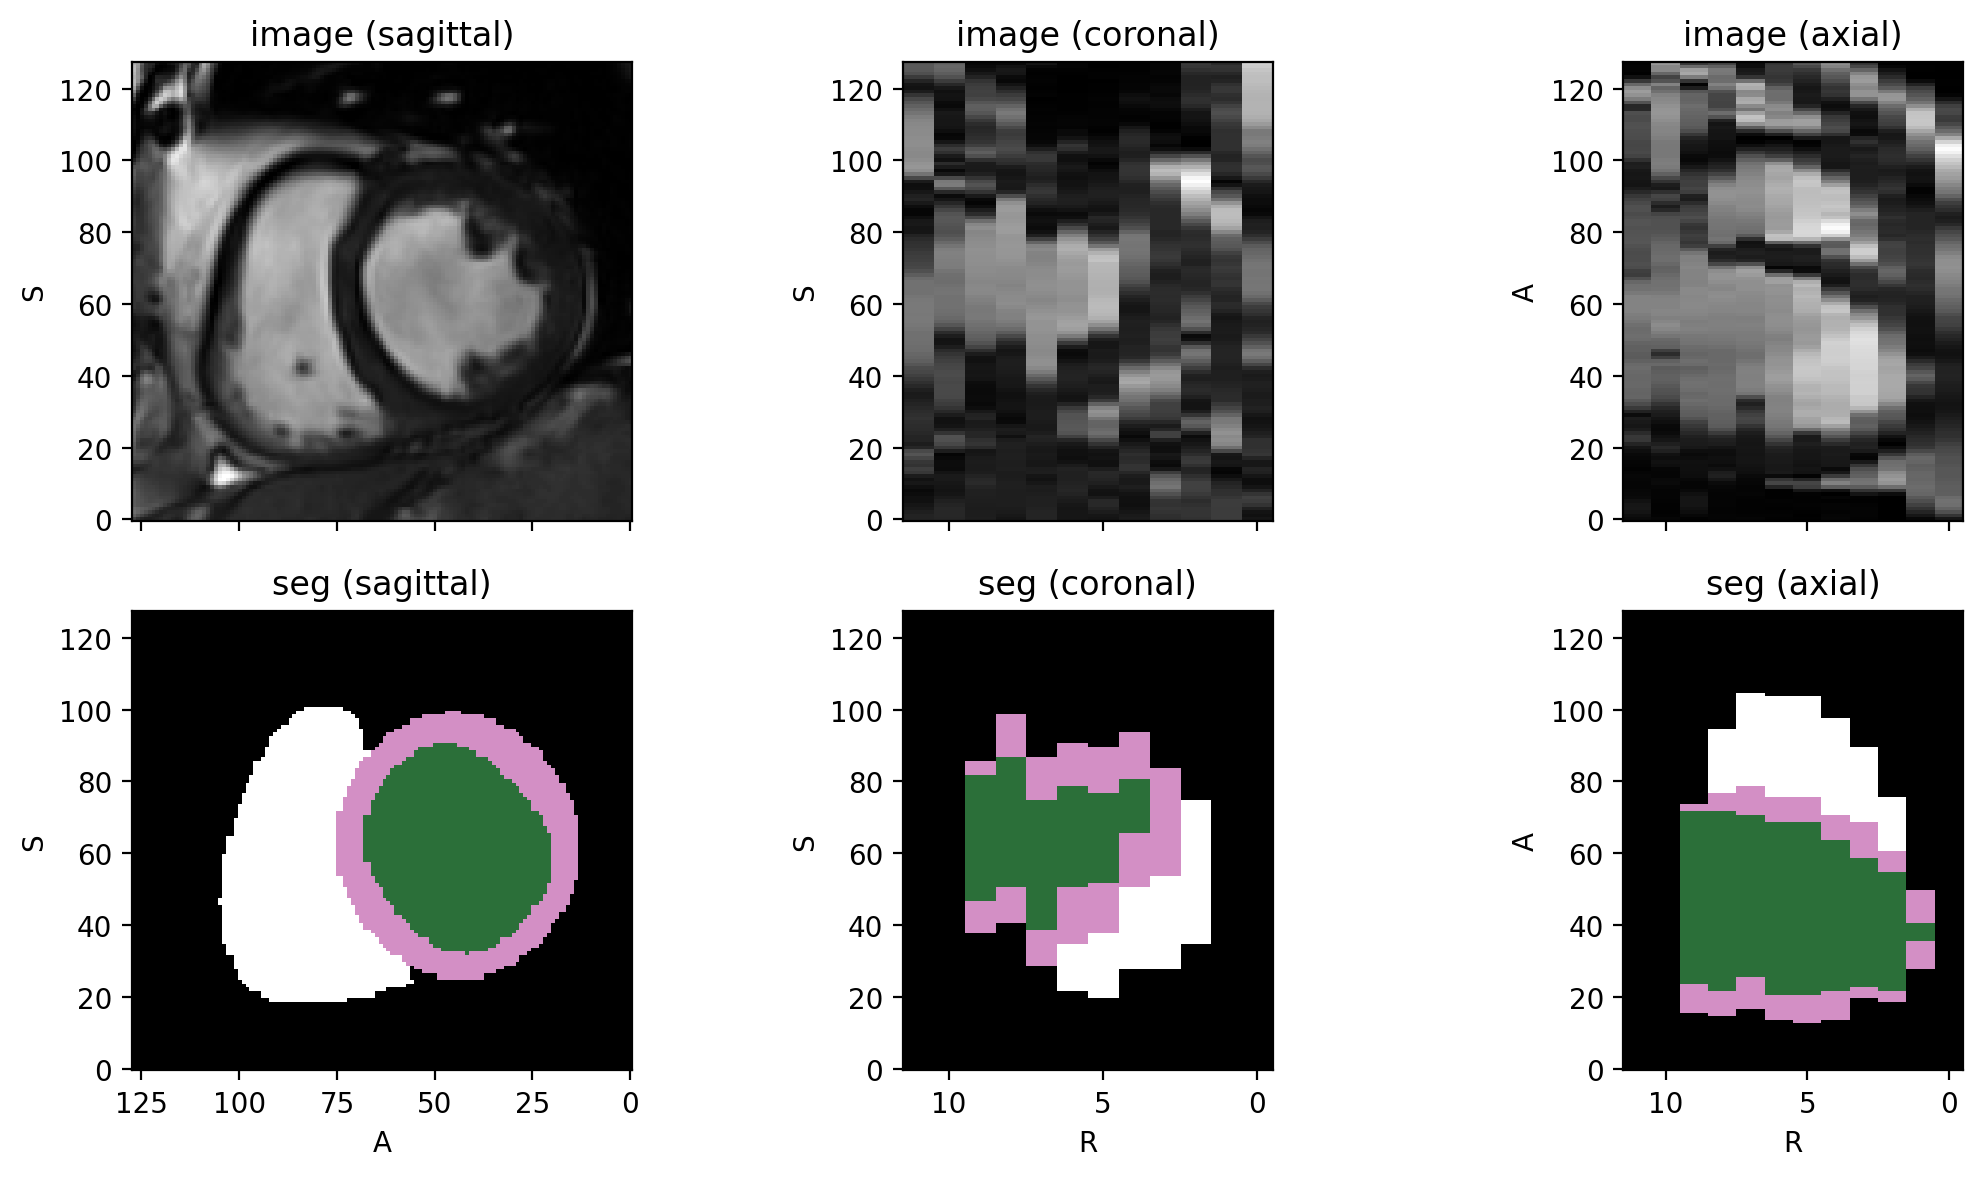

In [58]:
train_dataset_3D = load_3D("Training/Labeled/")
print("Total memory for train: ", get_total_memory(train_dataset_3D))
one_subject = train_dataset_3D[0]
visualize_subject(one_subject)

100%|██████████| 150/150 [00:16<00:00,  9.08it/s]


Training/Labeled/ Dataset size: 3286 subjects


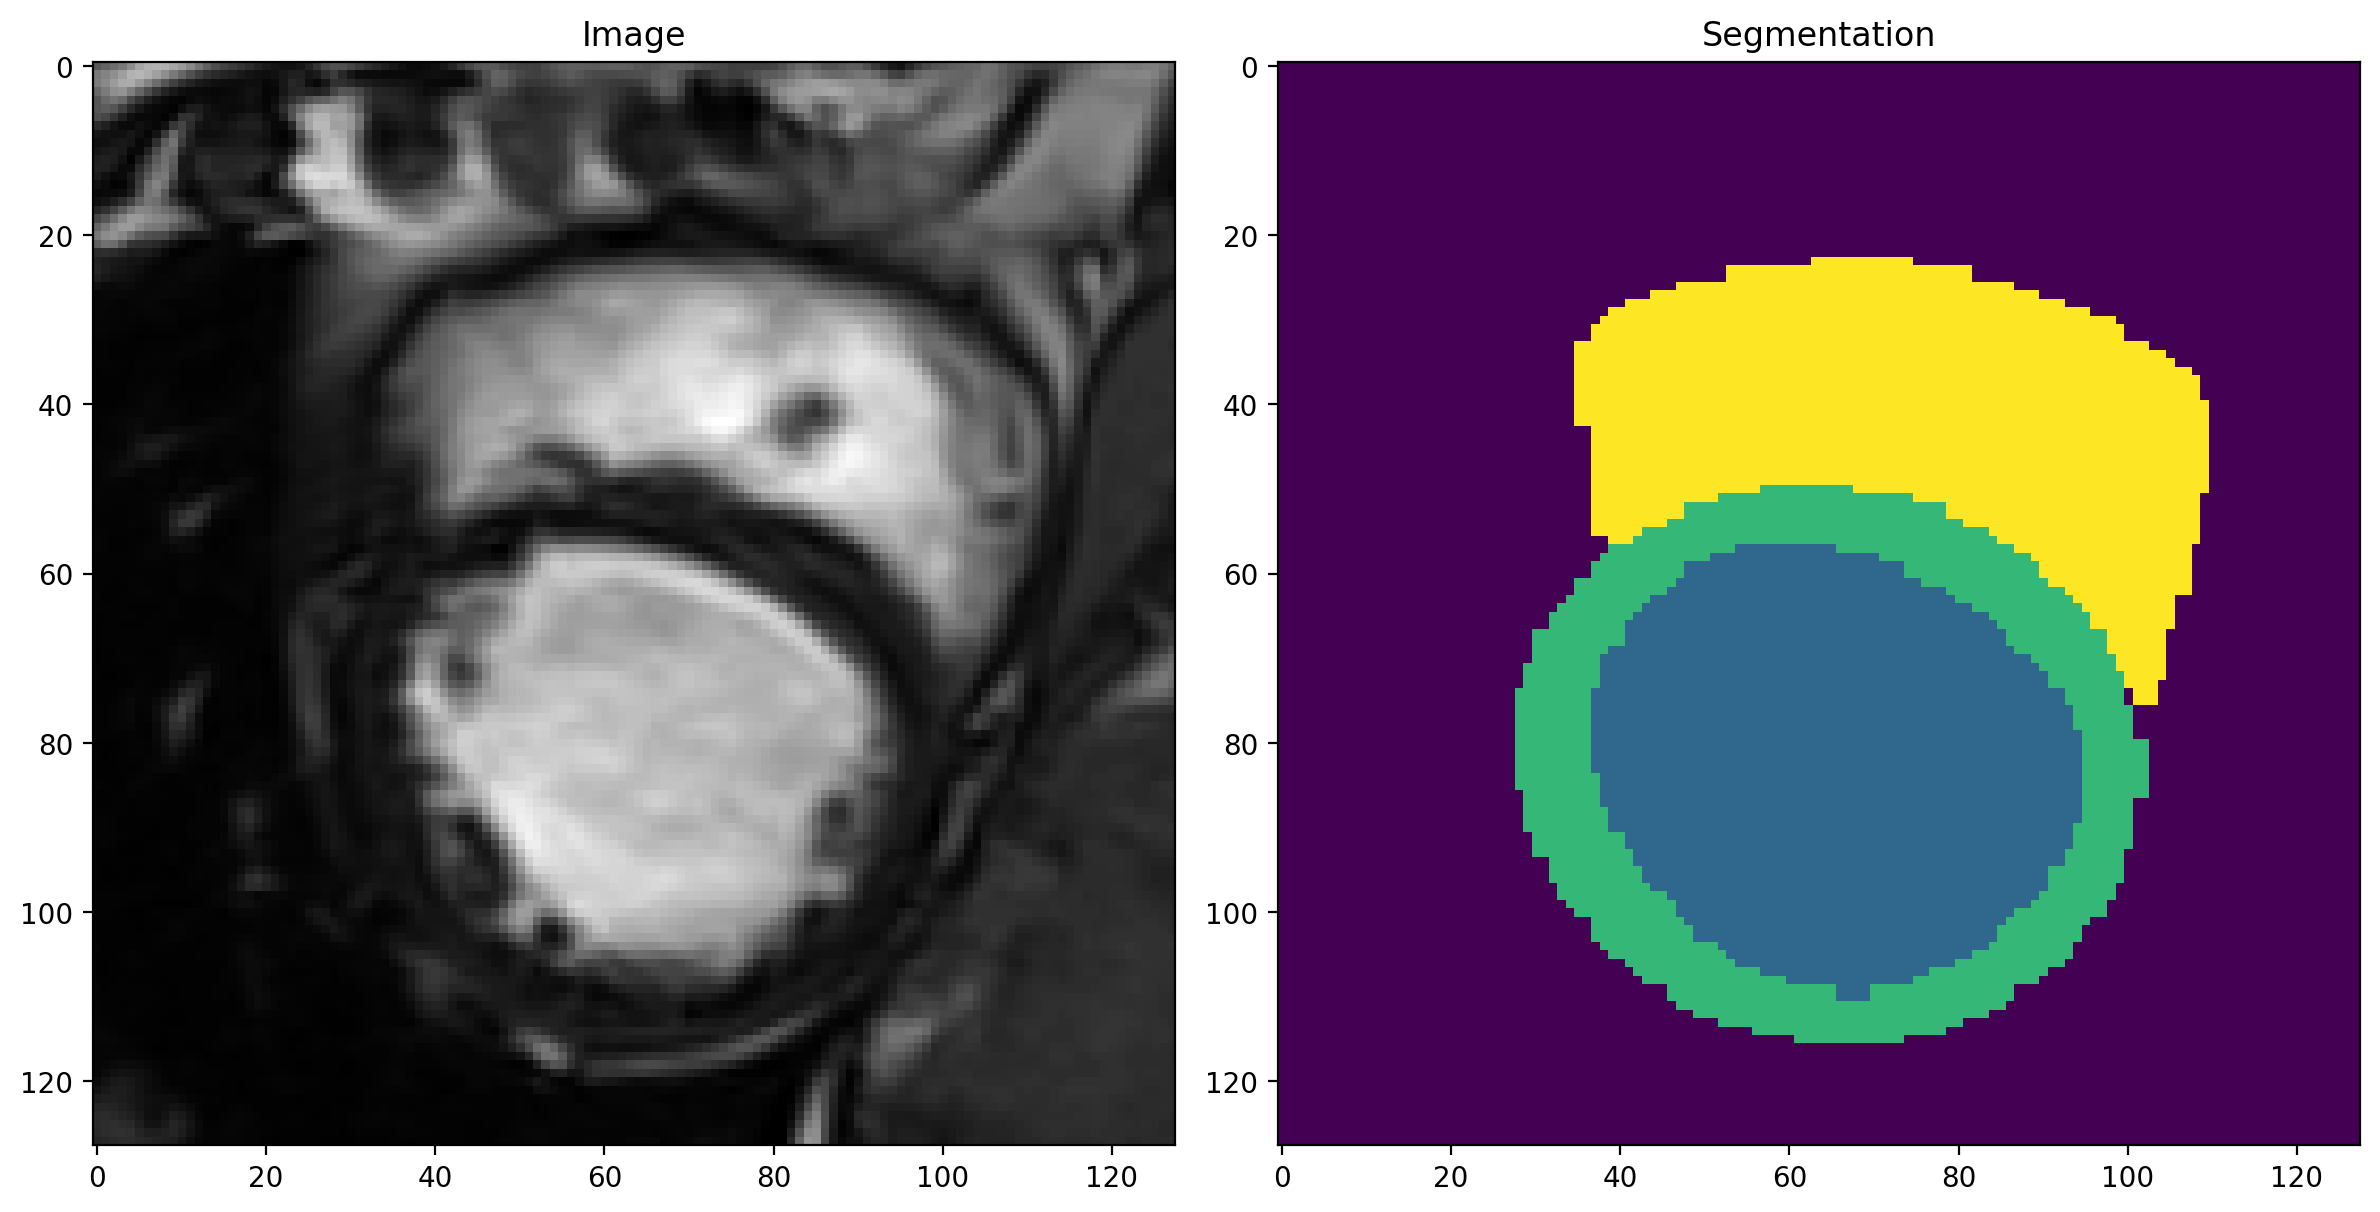

In [106]:
train_dataset = load_2D("Training/Labeled/")
image = train_dataset[10][0]
seg = train_dataset[10][1]
visualize_slice(image, seg)

In [204]:
# # C8J7L5 was removed from valid
valid_dataset = load_2D("Validation/")
# #E3F5U2, C8O0P2 were removed from test
# test_dataset = load_2D("Testing/")

100%|██████████| 33/33 [00:06<00:00,  4.99it/s]


Validation/ Dataset size: 786 subjects


# Unet

In [166]:
training_batch_size = 8
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=2,
)

dataiter = iter(training_loader)
images, labels = next(dataiter)

In [167]:
images.shape

torch.Size([8, 1, 128, 128])

In [234]:
def imshow(img, seg=None):
    npimg = img.numpy()[0]
    plt.figure(figsize=(4,8))
    plt.imshow(npimg, "gray")
    if seg is not None:
        seg = seg.numpy()[0]
        cmap = plt.colormaps.get_cmap('jet')
        masked = np.ma.masked_where(seg == 0, seg)
        plt.imshow(masked, cmap=cmap, alpha=0.7)

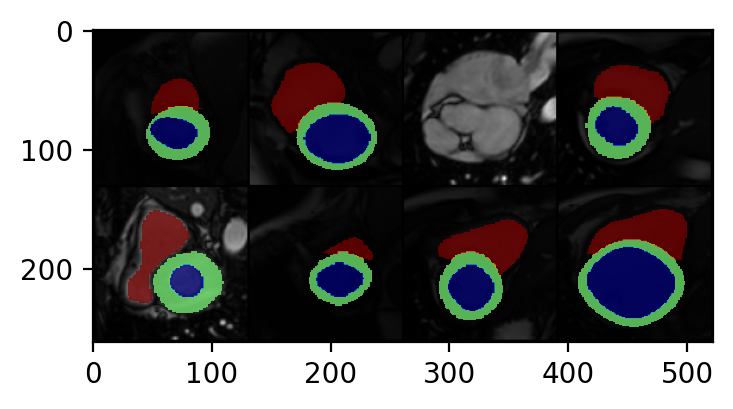

In [235]:
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images,nrow=4), torchvision.utils.make_grid(labels,nrow=4))

In [213]:
batch_size = 64
num_classes = 4


training_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10,
    )

validation_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=10
    )

num_epochs = 100
total_steps = len(training_loader)

model = UNet(
    in_channels=1,
    out_classes=4,
    dimensions=2,
    num_encoding_blocks=3,
    out_channels_first_layer=8,
    normalization='batch',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
).to(device)
model.to(device)


optimizer = torch.optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()


for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images_batch, labels_batch) in enumerate(training_loader):
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Step [10/52], Loss: 1.1535
Epoch [1/100], Step [20/52], Loss: 1.1114
Epoch [1/100], Step [30/52], Loss: 1.0519
Epoch [1/100], Step [40/52], Loss: 1.0040
Epoch [1/100], Step [50/52], Loss: 0.9328


  1%|          | 1/100 [00:04<07:16,  4.41s/it]

Epoch [2/100], Step [10/52], Loss: 0.8937
Epoch [2/100], Step [20/52], Loss: 0.8495
Epoch [2/100], Step [30/52], Loss: 0.8233
Epoch [2/100], Step [40/52], Loss: 0.7976
Epoch [2/100], Step [50/52], Loss: 0.7575


  2%|▏         | 2/100 [00:08<07:03,  4.32s/it]

Epoch [3/100], Step [10/52], Loss: 0.7363
Epoch [3/100], Step [20/52], Loss: 0.7187
Epoch [3/100], Step [30/52], Loss: 0.6617
Epoch [3/100], Step [40/52], Loss: 0.6427
Epoch [3/100], Step [50/52], Loss: 0.6269


  3%|▎         | 3/100 [00:13<06:59,  4.33s/it]

Epoch [4/100], Step [10/52], Loss: 0.6175
Epoch [4/100], Step [20/52], Loss: 0.5871
Epoch [4/100], Step [30/52], Loss: 0.5728
Epoch [4/100], Step [40/52], Loss: 0.5385
Epoch [4/100], Step [50/52], Loss: 0.5388


  4%|▍         | 4/100 [00:17<07:02,  4.40s/it]

Epoch [5/100], Step [10/52], Loss: 0.5543
Epoch [5/100], Step [20/52], Loss: 0.5044
Epoch [5/100], Step [30/52], Loss: 0.5044
Epoch [5/100], Step [40/52], Loss: 0.4621
Epoch [5/100], Step [50/52], Loss: 0.4854


  5%|▌         | 5/100 [00:21<06:53,  4.35s/it]

Epoch [6/100], Step [10/52], Loss: 0.4500
Epoch [6/100], Step [20/52], Loss: 0.4375
Epoch [6/100], Step [30/52], Loss: 0.4002
Epoch [6/100], Step [40/52], Loss: 0.4101
Epoch [6/100], Step [50/52], Loss: 0.3661


  6%|▌         | 6/100 [00:26<06:45,  4.32s/it]

Epoch [7/100], Step [10/52], Loss: 0.3543
Epoch [7/100], Step [20/52], Loss: 0.3685
Epoch [7/100], Step [30/52], Loss: 0.3876
Epoch [7/100], Step [40/52], Loss: 0.3742
Epoch [7/100], Step [50/52], Loss: 0.3530


  7%|▋         | 7/100 [00:30<06:40,  4.30s/it]

Epoch [8/100], Step [10/52], Loss: 0.3121
Epoch [8/100], Step [20/52], Loss: 0.3718
Epoch [8/100], Step [30/52], Loss: 0.3309
Epoch [8/100], Step [40/52], Loss: 0.3383
Epoch [8/100], Step [50/52], Loss: 0.3171


  8%|▊         | 8/100 [00:34<06:36,  4.31s/it]

Epoch [9/100], Step [10/52], Loss: 0.3249
Epoch [9/100], Step [20/52], Loss: 0.3232
Epoch [9/100], Step [30/52], Loss: 0.3170
Epoch [9/100], Step [40/52], Loss: 0.3178
Epoch [9/100], Step [50/52], Loss: 0.3083


  9%|▉         | 9/100 [00:38<06:32,  4.31s/it]

Epoch [10/100], Step [10/52], Loss: 0.3092
Epoch [10/100], Step [20/52], Loss: 0.3438
Epoch [10/100], Step [30/52], Loss: 0.2914
Epoch [10/100], Step [40/52], Loss: 0.2979
Epoch [10/100], Step [50/52], Loss: 0.3550


 10%|█         | 10/100 [00:43<06:27,  4.31s/it]

Epoch [11/100], Step [10/52], Loss: 0.3183
Epoch [11/100], Step [20/52], Loss: 0.3040
Epoch [11/100], Step [30/52], Loss: 0.2872
Epoch [11/100], Step [40/52], Loss: 0.2719
Epoch [11/100], Step [50/52], Loss: 0.2454


 11%|█         | 11/100 [00:47<06:23,  4.31s/it]

Epoch [12/100], Step [10/52], Loss: 0.2732
Epoch [12/100], Step [20/52], Loss: 0.2859
Epoch [12/100], Step [30/52], Loss: 0.2866
Epoch [12/100], Step [40/52], Loss: 0.2624
Epoch [12/100], Step [50/52], Loss: 0.2609


 12%|█▏        | 12/100 [00:51<06:20,  4.32s/it]

Epoch [13/100], Step [10/52], Loss: 0.2570
Epoch [13/100], Step [20/52], Loss: 0.2648
Epoch [13/100], Step [30/52], Loss: 0.2331
Epoch [13/100], Step [40/52], Loss: 0.2633
Epoch [13/100], Step [50/52], Loss: 0.2717


 13%|█▎        | 13/100 [00:56<06:20,  4.37s/it]

Epoch [14/100], Step [10/52], Loss: 0.2457
Epoch [14/100], Step [20/52], Loss: 0.2412
Epoch [14/100], Step [30/52], Loss: 0.2457
Epoch [14/100], Step [40/52], Loss: 0.2320
Epoch [14/100], Step [50/52], Loss: 0.2413


 14%|█▍        | 14/100 [01:00<06:13,  4.34s/it]

Epoch [15/100], Step [10/52], Loss: 0.2137
Epoch [15/100], Step [20/52], Loss: 0.2357
Epoch [15/100], Step [30/52], Loss: 0.2380
Epoch [15/100], Step [40/52], Loss: 0.2051
Epoch [15/100], Step [50/52], Loss: 0.2222


 15%|█▌        | 15/100 [01:04<06:08,  4.34s/it]

Epoch [16/100], Step [10/52], Loss: 0.2026
Epoch [16/100], Step [20/52], Loss: 0.2107
Epoch [16/100], Step [30/52], Loss: 0.2144
Epoch [16/100], Step [40/52], Loss: 0.2102
Epoch [16/100], Step [50/52], Loss: 0.2181


 16%|█▌        | 16/100 [01:09<06:03,  4.32s/it]

Epoch [17/100], Step [10/52], Loss: 0.2016
Epoch [17/100], Step [20/52], Loss: 0.1961
Epoch [17/100], Step [30/52], Loss: 0.1988
Epoch [17/100], Step [40/52], Loss: 0.2359
Epoch [17/100], Step [50/52], Loss: 0.2009


 17%|█▋        | 17/100 [01:13<05:59,  4.34s/it]

Epoch [18/100], Step [10/52], Loss: 0.2087
Epoch [18/100], Step [20/52], Loss: 0.1935
Epoch [18/100], Step [30/52], Loss: 0.2031
Epoch [18/100], Step [40/52], Loss: 0.1825
Epoch [18/100], Step [50/52], Loss: 0.2165


 18%|█▊        | 18/100 [01:18<05:57,  4.36s/it]

Epoch [19/100], Step [10/52], Loss: 0.2083
Epoch [19/100], Step [20/52], Loss: 0.1628
Epoch [19/100], Step [30/52], Loss: 0.1806
Epoch [19/100], Step [40/52], Loss: 0.2071
Epoch [19/100], Step [50/52], Loss: 0.1960


 19%|█▉        | 19/100 [01:22<05:50,  4.33s/it]

Epoch [20/100], Step [10/52], Loss: 0.2301
Epoch [20/100], Step [20/52], Loss: 0.1982
Epoch [20/100], Step [30/52], Loss: 0.1958
Epoch [20/100], Step [40/52], Loss: 0.1626
Epoch [20/100], Step [50/52], Loss: 0.2158


 20%|██        | 20/100 [01:26<05:43,  4.29s/it]

Epoch [21/100], Step [10/52], Loss: 0.1782
Epoch [21/100], Step [20/52], Loss: 0.1728
Epoch [21/100], Step [30/52], Loss: 0.1614
Epoch [21/100], Step [40/52], Loss: 0.1641
Epoch [21/100], Step [50/52], Loss: 0.1883


 21%|██        | 21/100 [01:31<05:44,  4.36s/it]

Epoch [22/100], Step [10/52], Loss: 0.1538
Epoch [22/100], Step [20/52], Loss: 0.1529
Epoch [22/100], Step [30/52], Loss: 0.1634
Epoch [22/100], Step [40/52], Loss: 0.1805
Epoch [22/100], Step [50/52], Loss: 0.1814


 22%|██▏       | 22/100 [01:35<05:40,  4.37s/it]

Epoch [23/100], Step [10/52], Loss: 0.1558
Epoch [23/100], Step [20/52], Loss: 0.1800
Epoch [23/100], Step [30/52], Loss: 0.1976
Epoch [23/100], Step [40/52], Loss: 0.1670
Epoch [23/100], Step [50/52], Loss: 0.1691


 23%|██▎       | 23/100 [01:39<05:33,  4.33s/it]

Epoch [24/100], Step [10/52], Loss: 0.1901
Epoch [24/100], Step [20/52], Loss: 0.1574
Epoch [24/100], Step [30/52], Loss: 0.1734
Epoch [24/100], Step [40/52], Loss: 0.1817
Epoch [24/100], Step [50/52], Loss: 0.1665


 24%|██▍       | 24/100 [01:43<05:28,  4.32s/it]

Epoch [25/100], Step [10/52], Loss: 0.1637
Epoch [25/100], Step [20/52], Loss: 0.1798
Epoch [25/100], Step [30/52], Loss: 0.1682
Epoch [25/100], Step [40/52], Loss: 0.1589
Epoch [25/100], Step [50/52], Loss: 0.1744


 25%|██▌       | 25/100 [01:48<05:23,  4.31s/it]

Epoch [26/100], Step [10/52], Loss: 0.1492
Epoch [26/100], Step [20/52], Loss: 0.1420
Epoch [26/100], Step [30/52], Loss: 0.1862
Epoch [26/100], Step [40/52], Loss: 0.1710
Epoch [26/100], Step [50/52], Loss: 0.1616


 26%|██▌       | 26/100 [01:52<05:19,  4.32s/it]

Epoch [27/100], Step [10/52], Loss: 0.1524
Epoch [27/100], Step [20/52], Loss: 0.1812
Epoch [27/100], Step [30/52], Loss: 0.1536
Epoch [27/100], Step [40/52], Loss: 0.1706
Epoch [27/100], Step [50/52], Loss: 0.1428


 27%|██▋       | 27/100 [01:56<05:15,  4.32s/it]

Epoch [28/100], Step [10/52], Loss: 0.1515
Epoch [28/100], Step [20/52], Loss: 0.1475
Epoch [28/100], Step [30/52], Loss: 0.1579
Epoch [28/100], Step [40/52], Loss: 0.1764
Epoch [28/100], Step [50/52], Loss: 0.1552


 28%|██▊       | 28/100 [02:01<05:11,  4.33s/it]

Epoch [29/100], Step [10/52], Loss: 0.1698
Epoch [29/100], Step [20/52], Loss: 0.1700
Epoch [29/100], Step [30/52], Loss: 0.1826
Epoch [29/100], Step [40/52], Loss: 0.1556
Epoch [29/100], Step [50/52], Loss: 0.1539


 29%|██▉       | 29/100 [02:05<05:07,  4.34s/it]

Epoch [30/100], Step [10/52], Loss: 0.1409
Epoch [30/100], Step [20/52], Loss: 0.1346
Epoch [30/100], Step [30/52], Loss: 0.1421
Epoch [30/100], Step [40/52], Loss: 0.1464
Epoch [30/100], Step [50/52], Loss: 0.1533


 30%|███       | 30/100 [02:10<05:08,  4.41s/it]

Epoch [31/100], Step [10/52], Loss: 0.1803
Epoch [31/100], Step [20/52], Loss: 0.1662
Epoch [31/100], Step [30/52], Loss: 0.1468
Epoch [31/100], Step [40/52], Loss: 0.1435
Epoch [31/100], Step [50/52], Loss: 0.1547


 31%|███       | 31/100 [02:14<05:02,  4.38s/it]

Epoch [32/100], Step [10/52], Loss: 0.1255
Epoch [32/100], Step [20/52], Loss: 0.1394
Epoch [32/100], Step [30/52], Loss: 0.1389
Epoch [32/100], Step [40/52], Loss: 0.1413
Epoch [32/100], Step [50/52], Loss: 0.1270


 32%|███▏      | 32/100 [02:18<04:56,  4.36s/it]

Epoch [33/100], Step [10/52], Loss: 0.1494
Epoch [33/100], Step [20/52], Loss: 0.1577
Epoch [33/100], Step [30/52], Loss: 0.1566
Epoch [33/100], Step [40/52], Loss: 0.1403
Epoch [33/100], Step [50/52], Loss: 0.1378


 33%|███▎      | 33/100 [02:23<04:50,  4.34s/it]

Epoch [34/100], Step [10/52], Loss: 0.1396
Epoch [34/100], Step [20/52], Loss: 0.1383
Epoch [34/100], Step [30/52], Loss: 0.1542
Epoch [34/100], Step [40/52], Loss: 0.1367
Epoch [34/100], Step [50/52], Loss: 0.1659


 34%|███▍      | 34/100 [02:27<04:45,  4.32s/it]

Epoch [35/100], Step [10/52], Loss: 0.1573
Epoch [35/100], Step [20/52], Loss: 0.1218
Epoch [35/100], Step [30/52], Loss: 0.1460
Epoch [35/100], Step [40/52], Loss: 0.1349
Epoch [35/100], Step [50/52], Loss: 0.1354


 35%|███▌      | 35/100 [02:31<04:41,  4.32s/it]

Epoch [36/100], Step [10/52], Loss: 0.1260
Epoch [36/100], Step [20/52], Loss: 0.1333
Epoch [36/100], Step [30/52], Loss: 0.1620
Epoch [36/100], Step [40/52], Loss: 0.1280
Epoch [36/100], Step [50/52], Loss: 0.1345


 36%|███▌      | 36/100 [02:36<04:37,  4.34s/it]

Epoch [37/100], Step [10/52], Loss: 0.1376
Epoch [37/100], Step [20/52], Loss: 0.1431
Epoch [37/100], Step [30/52], Loss: 0.1617
Epoch [37/100], Step [40/52], Loss: 0.1525
Epoch [37/100], Step [50/52], Loss: 0.1430


 37%|███▋      | 37/100 [02:40<04:32,  4.33s/it]

Epoch [38/100], Step [10/52], Loss: 0.1293
Epoch [38/100], Step [20/52], Loss: 0.1767
Epoch [38/100], Step [30/52], Loss: 0.1399
Epoch [38/100], Step [40/52], Loss: 0.1248
Epoch [38/100], Step [50/52], Loss: 0.1907


 38%|███▊      | 38/100 [02:44<04:30,  4.36s/it]

Epoch [39/100], Step [10/52], Loss: 0.1607
Epoch [39/100], Step [20/52], Loss: 0.1456
Epoch [39/100], Step [30/52], Loss: 0.1464
Epoch [39/100], Step [40/52], Loss: 0.1280
Epoch [39/100], Step [50/52], Loss: 0.1341


 39%|███▉      | 39/100 [02:49<04:26,  4.37s/it]

Epoch [40/100], Step [10/52], Loss: 0.1324
Epoch [40/100], Step [20/52], Loss: 0.1298
Epoch [40/100], Step [30/52], Loss: 0.1550
Epoch [40/100], Step [40/52], Loss: 0.1413
Epoch [40/100], Step [50/52], Loss: 0.1338


 40%|████      | 40/100 [02:53<04:21,  4.35s/it]

Epoch [41/100], Step [10/52], Loss: 0.1187
Epoch [41/100], Step [20/52], Loss: 0.1297
Epoch [41/100], Step [30/52], Loss: 0.1332
Epoch [41/100], Step [40/52], Loss: 0.1268
Epoch [41/100], Step [50/52], Loss: 0.1484


 41%|████      | 41/100 [02:57<04:16,  4.35s/it]

Epoch [42/100], Step [10/52], Loss: 0.1285
Epoch [42/100], Step [20/52], Loss: 0.1208
Epoch [42/100], Step [30/52], Loss: 0.1367
Epoch [42/100], Step [40/52], Loss: 0.1303
Epoch [42/100], Step [50/52], Loss: 0.1347


 42%|████▏     | 42/100 [03:02<04:10,  4.32s/it]

Epoch [43/100], Step [10/52], Loss: 0.1117
Epoch [43/100], Step [20/52], Loss: 0.1151
Epoch [43/100], Step [30/52], Loss: 0.1365
Epoch [43/100], Step [40/52], Loss: 0.1409
Epoch [43/100], Step [50/52], Loss: 0.1306


 43%|████▎     | 43/100 [03:06<04:06,  4.32s/it]

Epoch [44/100], Step [10/52], Loss: 0.1244
Epoch [44/100], Step [20/52], Loss: 0.1527
Epoch [44/100], Step [30/52], Loss: 0.1229
Epoch [44/100], Step [40/52], Loss: 0.1176
Epoch [44/100], Step [50/52], Loss: 0.1435


 44%|████▍     | 44/100 [03:10<04:02,  4.33s/it]

Epoch [45/100], Step [10/52], Loss: 0.1064
Epoch [45/100], Step [20/52], Loss: 0.1196
Epoch [45/100], Step [30/52], Loss: 0.1272
Epoch [45/100], Step [40/52], Loss: 0.1320
Epoch [45/100], Step [50/52], Loss: 0.1241


 45%|████▌     | 45/100 [03:15<03:57,  4.32s/it]

Epoch [46/100], Step [10/52], Loss: 0.1336
Epoch [46/100], Step [20/52], Loss: 0.1294
Epoch [46/100], Step [30/52], Loss: 0.1159
Epoch [46/100], Step [40/52], Loss: 0.1208
Epoch [46/100], Step [50/52], Loss: 0.1621


 46%|████▌     | 46/100 [03:19<03:52,  4.31s/it]

Epoch [47/100], Step [10/52], Loss: 0.1171
Epoch [47/100], Step [20/52], Loss: 0.1229
Epoch [47/100], Step [30/52], Loss: 0.1440
Epoch [47/100], Step [40/52], Loss: 0.1304
Epoch [47/100], Step [50/52], Loss: 0.1315


 47%|████▋     | 47/100 [03:23<03:49,  4.34s/it]

Epoch [48/100], Step [10/52], Loss: 0.1418
Epoch [48/100], Step [20/52], Loss: 0.1440
Epoch [48/100], Step [30/52], Loss: 0.1220
Epoch [48/100], Step [40/52], Loss: 0.1083
Epoch [48/100], Step [50/52], Loss: 0.1194


 48%|████▊     | 48/100 [03:28<03:47,  4.38s/it]

Epoch [49/100], Step [10/52], Loss: 0.1118
Epoch [49/100], Step [20/52], Loss: 0.1347
Epoch [49/100], Step [30/52], Loss: 0.1378
Epoch [49/100], Step [40/52], Loss: 0.1111
Epoch [49/100], Step [50/52], Loss: 0.1667


 49%|████▉     | 49/100 [03:32<03:42,  4.37s/it]

Epoch [50/100], Step [10/52], Loss: 0.1368
Epoch [50/100], Step [20/52], Loss: 0.1230
Epoch [50/100], Step [30/52], Loss: 0.1173
Epoch [50/100], Step [40/52], Loss: 0.1227
Epoch [50/100], Step [50/52], Loss: 0.1277


 50%|█████     | 50/100 [03:36<03:38,  4.36s/it]

Epoch [51/100], Step [10/52], Loss: 0.1200
Epoch [51/100], Step [20/52], Loss: 0.1652
Epoch [51/100], Step [30/52], Loss: 0.1171
Epoch [51/100], Step [40/52], Loss: 0.1517
Epoch [51/100], Step [50/52], Loss: 0.1367


 51%|█████     | 51/100 [03:41<03:33,  4.35s/it]

Epoch [52/100], Step [10/52], Loss: 0.1224
Epoch [52/100], Step [20/52], Loss: 0.1219
Epoch [52/100], Step [30/52], Loss: 0.1305
Epoch [52/100], Step [40/52], Loss: 0.1308
Epoch [52/100], Step [50/52], Loss: 0.1294


 52%|█████▏    | 52/100 [03:45<03:28,  4.34s/it]

Epoch [53/100], Step [10/52], Loss: 0.1361
Epoch [53/100], Step [20/52], Loss: 0.1154
Epoch [53/100], Step [30/52], Loss: 0.1098
Epoch [53/100], Step [40/52], Loss: 0.1292
Epoch [53/100], Step [50/52], Loss: 0.1366


 53%|█████▎    | 53/100 [03:49<03:23,  4.34s/it]

Epoch [54/100], Step [10/52], Loss: 0.1501
Epoch [54/100], Step [20/52], Loss: 0.1069
Epoch [54/100], Step [30/52], Loss: 0.1398
Epoch [54/100], Step [40/52], Loss: 0.1442
Epoch [54/100], Step [50/52], Loss: 0.1336


 54%|█████▍    | 54/100 [03:54<03:18,  4.32s/it]

Epoch [55/100], Step [10/52], Loss: 0.1388
Epoch [55/100], Step [20/52], Loss: 0.1205
Epoch [55/100], Step [30/52], Loss: 0.1459
Epoch [55/100], Step [40/52], Loss: 0.1341
Epoch [55/100], Step [50/52], Loss: 0.1221


 55%|█████▌    | 55/100 [03:58<03:14,  4.32s/it]

Epoch [56/100], Step [10/52], Loss: 0.1300
Epoch [56/100], Step [20/52], Loss: 0.1466
Epoch [56/100], Step [30/52], Loss: 0.1239
Epoch [56/100], Step [40/52], Loss: 0.1195
Epoch [56/100], Step [50/52], Loss: 0.1097


 56%|█████▌    | 56/100 [04:02<03:11,  4.36s/it]

Epoch [57/100], Step [10/52], Loss: 0.1260
Epoch [57/100], Step [20/52], Loss: 0.1178
Epoch [57/100], Step [30/52], Loss: 0.1064
Epoch [57/100], Step [40/52], Loss: 0.1274
Epoch [57/100], Step [50/52], Loss: 0.1550


 57%|█████▋    | 57/100 [04:07<03:07,  4.35s/it]

Epoch [58/100], Step [10/52], Loss: 0.1070
Epoch [58/100], Step [20/52], Loss: 0.1258
Epoch [58/100], Step [30/52], Loss: 0.1229
Epoch [58/100], Step [40/52], Loss: 0.1139
Epoch [58/100], Step [50/52], Loss: 0.1125


 58%|█████▊    | 58/100 [04:11<03:01,  4.32s/it]

Epoch [59/100], Step [10/52], Loss: 0.0989
Epoch [59/100], Step [20/52], Loss: 0.1233
Epoch [59/100], Step [30/52], Loss: 0.1103
Epoch [59/100], Step [40/52], Loss: 0.1560
Epoch [59/100], Step [50/52], Loss: 0.1174


 59%|█████▉    | 59/100 [04:15<02:55,  4.29s/it]

Epoch [60/100], Step [10/52], Loss: 0.1163
Epoch [60/100], Step [20/52], Loss: 0.1243
Epoch [60/100], Step [30/52], Loss: 0.1383
Epoch [60/100], Step [40/52], Loss: 0.1461
Epoch [60/100], Step [50/52], Loss: 0.1463


 60%|██████    | 60/100 [04:20<02:52,  4.31s/it]

Epoch [61/100], Step [10/52], Loss: 0.0996
Epoch [61/100], Step [20/52], Loss: 0.1236
Epoch [61/100], Step [30/52], Loss: 0.1116
Epoch [61/100], Step [40/52], Loss: 0.1581
Epoch [61/100], Step [50/52], Loss: 0.1259


 61%|██████    | 61/100 [04:24<02:48,  4.32s/it]

Epoch [62/100], Step [10/52], Loss: 0.1472
Epoch [62/100], Step [20/52], Loss: 0.1174
Epoch [62/100], Step [30/52], Loss: 0.1138
Epoch [62/100], Step [40/52], Loss: 0.1165
Epoch [62/100], Step [50/52], Loss: 0.1513


 62%|██████▏   | 62/100 [04:28<02:43,  4.30s/it]

Epoch [63/100], Step [10/52], Loss: 0.1072
Epoch [63/100], Step [20/52], Loss: 0.1219
Epoch [63/100], Step [30/52], Loss: 0.1357
Epoch [63/100], Step [40/52], Loss: 0.1282
Epoch [63/100], Step [50/52], Loss: 0.1170


 63%|██████▎   | 63/100 [04:32<02:38,  4.29s/it]

Epoch [64/100], Step [10/52], Loss: 0.1162
Epoch [64/100], Step [20/52], Loss: 0.1181
Epoch [64/100], Step [30/52], Loss: 0.1181
Epoch [64/100], Step [40/52], Loss: 0.1141
Epoch [64/100], Step [50/52], Loss: 0.1195


 64%|██████▍   | 64/100 [04:37<02:34,  4.30s/it]

Epoch [65/100], Step [10/52], Loss: 0.1068
Epoch [65/100], Step [20/52], Loss: 0.1022
Epoch [65/100], Step [30/52], Loss: 0.1039
Epoch [65/100], Step [40/52], Loss: 0.1288
Epoch [65/100], Step [50/52], Loss: 0.1100


 65%|██████▌   | 65/100 [04:41<02:30,  4.31s/it]

Epoch [66/100], Step [10/52], Loss: 0.1107
Epoch [66/100], Step [20/52], Loss: 0.1150
Epoch [66/100], Step [30/52], Loss: 0.1088
Epoch [66/100], Step [40/52], Loss: 0.1133
Epoch [66/100], Step [50/52], Loss: 0.1248


 66%|██████▌   | 66/100 [04:46<02:27,  4.35s/it]

Epoch [67/100], Step [10/52], Loss: 0.1325
Epoch [67/100], Step [20/52], Loss: 0.1273
Epoch [67/100], Step [30/52], Loss: 0.1202
Epoch [67/100], Step [40/52], Loss: 0.1271
Epoch [67/100], Step [50/52], Loss: 0.1141


 67%|██████▋   | 67/100 [04:50<02:22,  4.32s/it]

Epoch [68/100], Step [10/52], Loss: 0.1138
Epoch [68/100], Step [20/52], Loss: 0.1177
Epoch [68/100], Step [30/52], Loss: 0.1046
Epoch [68/100], Step [40/52], Loss: 0.1145
Epoch [68/100], Step [50/52], Loss: 0.1193


 68%|██████▊   | 68/100 [04:54<02:18,  4.31s/it]

Epoch [69/100], Step [10/52], Loss: 0.1139
Epoch [69/100], Step [20/52], Loss: 0.1268
Epoch [69/100], Step [30/52], Loss: 0.1154
Epoch [69/100], Step [40/52], Loss: 0.1430
Epoch [69/100], Step [50/52], Loss: 0.1247


 69%|██████▉   | 69/100 [04:58<02:14,  4.32s/it]

Epoch [70/100], Step [10/52], Loss: 0.1322
Epoch [70/100], Step [20/52], Loss: 0.1075
Epoch [70/100], Step [30/52], Loss: 0.1150
Epoch [70/100], Step [40/52], Loss: 0.1353
Epoch [70/100], Step [50/52], Loss: 0.1067


 70%|███████   | 70/100 [05:03<02:09,  4.33s/it]

Epoch [71/100], Step [10/52], Loss: 0.1046
Epoch [71/100], Step [20/52], Loss: 0.1211
Epoch [71/100], Step [30/52], Loss: 0.0971
Epoch [71/100], Step [40/52], Loss: 0.1056
Epoch [71/100], Step [50/52], Loss: 0.1145


 71%|███████   | 71/100 [05:07<02:05,  4.32s/it]

Epoch [72/100], Step [10/52], Loss: 0.1352
Epoch [72/100], Step [20/52], Loss: 0.0993
Epoch [72/100], Step [30/52], Loss: 0.1242
Epoch [72/100], Step [40/52], Loss: 0.1380
Epoch [72/100], Step [50/52], Loss: 0.1227


 72%|███████▏  | 72/100 [05:12<02:01,  4.33s/it]

Epoch [73/100], Step [10/52], Loss: 0.1290
Epoch [73/100], Step [20/52], Loss: 0.1104
Epoch [73/100], Step [30/52], Loss: 0.1177
Epoch [73/100], Step [40/52], Loss: 0.1094
Epoch [73/100], Step [50/52], Loss: 0.1390


 73%|███████▎  | 73/100 [05:16<01:57,  4.35s/it]

Epoch [74/100], Step [10/52], Loss: 0.1059
Epoch [74/100], Step [20/52], Loss: 0.1471
Epoch [74/100], Step [30/52], Loss: 0.1070
Epoch [74/100], Step [40/52], Loss: 0.1040
Epoch [74/100], Step [50/52], Loss: 0.0906


 74%|███████▍  | 74/100 [05:20<01:54,  4.39s/it]

Epoch [75/100], Step [10/52], Loss: 0.1045
Epoch [75/100], Step [20/52], Loss: 0.1282
Epoch [75/100], Step [30/52], Loss: 0.1206
Epoch [75/100], Step [40/52], Loss: 0.1089
Epoch [75/100], Step [50/52], Loss: 0.0940


 75%|███████▌  | 75/100 [05:25<01:49,  4.40s/it]

Epoch [76/100], Step [10/52], Loss: 0.1248
Epoch [76/100], Step [20/52], Loss: 0.1178
Epoch [76/100], Step [30/52], Loss: 0.1095
Epoch [76/100], Step [40/52], Loss: 0.1212
Epoch [76/100], Step [50/52], Loss: 0.1166


 76%|███████▌  | 76/100 [05:29<01:44,  4.35s/it]

Epoch [77/100], Step [10/52], Loss: 0.1031
Epoch [77/100], Step [20/52], Loss: 0.1118
Epoch [77/100], Step [30/52], Loss: 0.1122
Epoch [77/100], Step [40/52], Loss: 0.1185
Epoch [77/100], Step [50/52], Loss: 0.1046


 77%|███████▋  | 77/100 [05:33<01:39,  4.34s/it]

Epoch [78/100], Step [10/52], Loss: 0.1061
Epoch [78/100], Step [20/52], Loss: 0.1035
Epoch [78/100], Step [30/52], Loss: 0.1153
Epoch [78/100], Step [40/52], Loss: 0.1190
Epoch [78/100], Step [50/52], Loss: 0.1317


 78%|███████▊  | 78/100 [05:38<01:35,  4.35s/it]

Epoch [79/100], Step [10/52], Loss: 0.1075
Epoch [79/100], Step [20/52], Loss: 0.1260
Epoch [79/100], Step [30/52], Loss: 0.1058
Epoch [79/100], Step [40/52], Loss: 0.1375
Epoch [79/100], Step [50/52], Loss: 0.1208


 79%|███████▉  | 79/100 [05:42<01:31,  4.34s/it]

Epoch [80/100], Step [10/52], Loss: 0.0943
Epoch [80/100], Step [20/52], Loss: 0.1121
Epoch [80/100], Step [30/52], Loss: 0.1216
Epoch [80/100], Step [40/52], Loss: 0.1164
Epoch [80/100], Step [50/52], Loss: 0.1274


 80%|████████  | 80/100 [05:46<01:27,  4.36s/it]

Epoch [81/100], Step [10/52], Loss: 0.1100
Epoch [81/100], Step [20/52], Loss: 0.1072
Epoch [81/100], Step [30/52], Loss: 0.1233
Epoch [81/100], Step [40/52], Loss: 0.1121
Epoch [81/100], Step [50/52], Loss: 0.1043


 81%|████████  | 81/100 [05:51<01:22,  4.36s/it]

Epoch [82/100], Step [10/52], Loss: 0.1066
Epoch [82/100], Step [20/52], Loss: 0.1023
Epoch [82/100], Step [30/52], Loss: 0.1174
Epoch [82/100], Step [40/52], Loss: 0.1090
Epoch [82/100], Step [50/52], Loss: 0.1153


 82%|████████▏ | 82/100 [05:55<01:17,  4.33s/it]

Epoch [83/100], Step [10/52], Loss: 0.1139
Epoch [83/100], Step [20/52], Loss: 0.1253
Epoch [83/100], Step [30/52], Loss: 0.1020
Epoch [83/100], Step [40/52], Loss: 0.1094
Epoch [83/100], Step [50/52], Loss: 0.1295


 83%|████████▎ | 83/100 [06:00<01:14,  4.37s/it]

Epoch [84/100], Step [10/52], Loss: 0.1195
Epoch [84/100], Step [20/52], Loss: 0.1060
Epoch [84/100], Step [30/52], Loss: 0.1133
Epoch [84/100], Step [40/52], Loss: 0.1175
Epoch [84/100], Step [50/52], Loss: 0.1197


 84%|████████▍ | 84/100 [06:04<01:09,  4.35s/it]

Epoch [85/100], Step [10/52], Loss: 0.1013
Epoch [85/100], Step [20/52], Loss: 0.0971
Epoch [85/100], Step [30/52], Loss: 0.1051
Epoch [85/100], Step [40/52], Loss: 0.1091
Epoch [85/100], Step [50/52], Loss: 0.1221


 85%|████████▌ | 85/100 [06:08<01:05,  4.33s/it]

Epoch [86/100], Step [10/52], Loss: 0.1280
Epoch [86/100], Step [20/52], Loss: 0.0987
Epoch [86/100], Step [30/52], Loss: 0.1115
Epoch [86/100], Step [40/52], Loss: 0.1014
Epoch [86/100], Step [50/52], Loss: 0.0974


 86%|████████▌ | 86/100 [06:12<01:00,  4.34s/it]

Epoch [87/100], Step [10/52], Loss: 0.1235
Epoch [87/100], Step [20/52], Loss: 0.1141
Epoch [87/100], Step [30/52], Loss: 0.1268
Epoch [87/100], Step [40/52], Loss: 0.1106
Epoch [87/100], Step [50/52], Loss: 0.1127


 87%|████████▋ | 87/100 [06:17<00:56,  4.35s/it]

Epoch [88/100], Step [10/52], Loss: 0.1171
Epoch [88/100], Step [20/52], Loss: 0.1152
Epoch [88/100], Step [30/52], Loss: 0.1449
Epoch [88/100], Step [40/52], Loss: 0.1223
Epoch [88/100], Step [50/52], Loss: 0.1056


 88%|████████▊ | 88/100 [06:21<00:52,  4.35s/it]

Epoch [89/100], Step [10/52], Loss: 0.0931
Epoch [89/100], Step [20/52], Loss: 0.0939
Epoch [89/100], Step [30/52], Loss: 0.1178
Epoch [89/100], Step [40/52], Loss: 0.1317
Epoch [89/100], Step [50/52], Loss: 0.1083


 89%|████████▉ | 89/100 [06:25<00:47,  4.32s/it]

Epoch [90/100], Step [10/52], Loss: 0.0887
Epoch [90/100], Step [20/52], Loss: 0.1184
Epoch [90/100], Step [30/52], Loss: 0.1179
Epoch [90/100], Step [40/52], Loss: 0.1237
Epoch [90/100], Step [50/52], Loss: 0.1207


 90%|█████████ | 90/100 [06:30<00:43,  4.33s/it]

Epoch [91/100], Step [10/52], Loss: 0.1094
Epoch [91/100], Step [20/52], Loss: 0.1041
Epoch [91/100], Step [30/52], Loss: 0.1007
Epoch [91/100], Step [40/52], Loss: 0.1242
Epoch [91/100], Step [50/52], Loss: 0.1126


 91%|█████████ | 91/100 [06:34<00:39,  4.36s/it]

Epoch [92/100], Step [10/52], Loss: 0.1095
Epoch [92/100], Step [20/52], Loss: 0.1253
Epoch [92/100], Step [30/52], Loss: 0.1099
Epoch [92/100], Step [40/52], Loss: 0.1172
Epoch [92/100], Step [50/52], Loss: 0.0856


 92%|█████████▏| 92/100 [06:39<00:35,  4.38s/it]

Epoch [93/100], Step [10/52], Loss: 0.1063
Epoch [93/100], Step [20/52], Loss: 0.0975
Epoch [93/100], Step [30/52], Loss: 0.1071
Epoch [93/100], Step [40/52], Loss: 0.0919
Epoch [93/100], Step [50/52], Loss: 0.1141


 93%|█████████▎| 93/100 [06:43<00:30,  4.34s/it]

Epoch [94/100], Step [10/52], Loss: 0.0961
Epoch [94/100], Step [20/52], Loss: 0.0967
Epoch [94/100], Step [30/52], Loss: 0.1088
Epoch [94/100], Step [40/52], Loss: 0.0919
Epoch [94/100], Step [50/52], Loss: 0.1164


 94%|█████████▍| 94/100 [06:47<00:25,  4.32s/it]

Epoch [95/100], Step [10/52], Loss: 0.1049
Epoch [95/100], Step [20/52], Loss: 0.1379
Epoch [95/100], Step [30/52], Loss: 0.1034
Epoch [95/100], Step [40/52], Loss: 0.1030
Epoch [95/100], Step [50/52], Loss: 0.1041


 95%|█████████▌| 95/100 [06:52<00:21,  4.35s/it]

Epoch [96/100], Step [10/52], Loss: 0.0949
Epoch [96/100], Step [20/52], Loss: 0.0982
Epoch [96/100], Step [30/52], Loss: 0.0975
Epoch [96/100], Step [40/52], Loss: 0.1018
Epoch [96/100], Step [50/52], Loss: 0.1072


 96%|█████████▌| 96/100 [06:56<00:17,  4.34s/it]

Epoch [97/100], Step [10/52], Loss: 0.1343
Epoch [97/100], Step [20/52], Loss: 0.0969
Epoch [97/100], Step [30/52], Loss: 0.1174
Epoch [97/100], Step [40/52], Loss: 0.1007
Epoch [97/100], Step [50/52], Loss: 0.1093


 97%|█████████▋| 97/100 [07:00<00:12,  4.33s/it]

Epoch [98/100], Step [10/52], Loss: 0.0952
Epoch [98/100], Step [20/52], Loss: 0.1034
Epoch [98/100], Step [30/52], Loss: 0.1326
Epoch [98/100], Step [40/52], Loss: 0.1127
Epoch [98/100], Step [50/52], Loss: 0.1020


 98%|█████████▊| 98/100 [07:05<00:08,  4.33s/it]

Epoch [99/100], Step [10/52], Loss: 0.1057
Epoch [99/100], Step [20/52], Loss: 0.1043
Epoch [99/100], Step [30/52], Loss: 0.1315
Epoch [99/100], Step [40/52], Loss: 0.1212
Epoch [99/100], Step [50/52], Loss: 0.1125


 99%|█████████▉| 99/100 [07:09<00:04,  4.33s/it]

Epoch [100/100], Step [10/52], Loss: 0.1239
Epoch [100/100], Step [20/52], Loss: 0.0961
Epoch [100/100], Step [30/52], Loss: 0.0950
Epoch [100/100], Step [40/52], Loss: 0.1321
Epoch [100/100], Step [50/52], Loss: 0.1280


100%|██████████| 100/100 [07:13<00:00,  4.34s/it]


In [229]:
valid_iter = iter(validation_loader)

In [231]:
validation_batch = next(valid_iter)  # Replace with your actual code to load the validation batch
images, ground_truths = validation_batch
images = images.to('cuda')

with torch.no_grad():
    output = model(images)

print(output.shape)
# If the model outputs probabilities
probabilities = torch.softmax(output, dim=1)
_, predictions = torch.max(probabilities, dim=1)
print(predictions.shape)

predictions = predictions.cpu()


torch.Size([64, 4, 128, 128])
torch.Size([64, 128, 128])


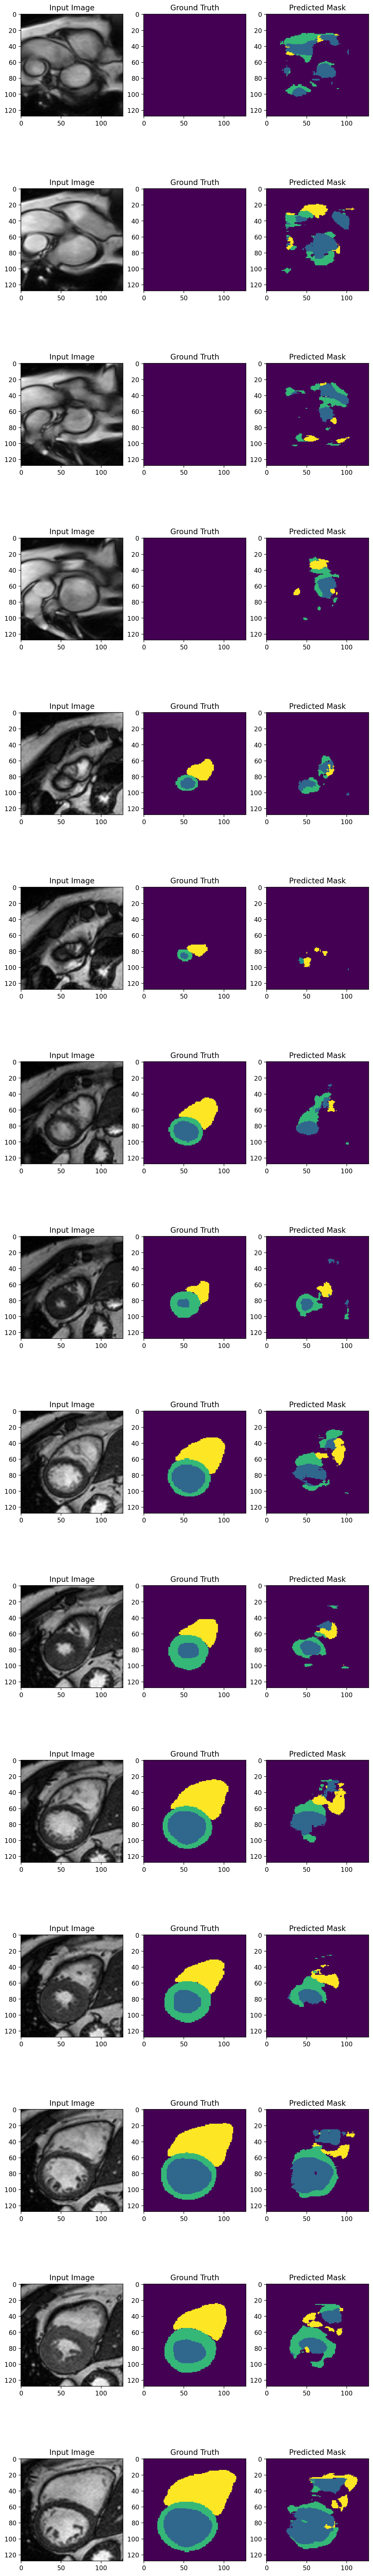

In [232]:
n_examples = 15
plt.figure(figsize=(10, 5 * n_examples))

for i in range(n_examples):
    input_image = images[i].cpu()
    ground_truth = ground_truths[i].cpu()
    predicted_mask = predictions[i]

    input_image = input_image.permute(1, 2, 0).numpy()
    ground_truth = ground_truth.permute(1, 2, 0).numpy()
    predicted_mask = predicted_mask.numpy()

    plt.subplot(n_examples, 3, i*3 + 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Input Image')

    plt.subplot(n_examples, 3, i*3 + 2)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')

    plt.subplot(n_examples, 3, i*3 + 3)
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask')

plt.show()